In [1]:
#Loading files
import re
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

with open("books.yaml", "r") as f:
    yaml_data = yaml.safe_load(f)

cleaned_yaml = [{k.lstrip(":"): v for k, v in row.items()} for row in yaml_data]
df_books = pd.DataFrame(cleaned_yaml)

df_orders = pd.read_parquet("orders.parquet")

df_users = pd.read_csv("users.csv")

In [2]:
print("Books:")
df_books.head(5)

Books:


,id,title,author,genre,publisher,year
0,21326,Behold the Man,"Trenton Sipes, Clint Hauck VM",Reference book,Bowes & Bowes,1979
1,21546,The Deer Hunter,Norris Gusikowski,Reference book,Koren Publishers Jerusalem,1993
2,21130,Snatch,Rev. Lura Jaskolski,Fable,Left Book Club,2000
3,21287,Dial M for Murder,Miss Elmo Walsh,Textbook,Libertas Academica,1977
4,21237,The Departed,Mario Aufderhar,Folklore,BBC Books,2015


In [3]:
print("\nOrders:")
df_orders.head(5)


Orders:


,id,user_id,book_id,quantity,unit_price,timestamp,shipping
0,75198,55590,21465,1,73.5$,"08:47:31 P.M.,10/07/24",NULL
1,82023,53482,21374,1,$25.00,2024-09-11T05:27:49,NULL
2,81439,55123,21408,1,USD22.50,"2024-08-06,06:53",
3,80259,54387,21013,1,42.5$,03/18/25;09:32:41 AM,
4,80176,54916,21437,1,$ 62.5,"04:55:14 pm,09/24/24",NULL


In [4]:
print("\nUsers:")
df_users.head(5)


Users:


,id,name,address,phone,email
0,53386,Jacqulyn Mante,"566 Emelina Turnpike, Lashundaside, NE 78034-5281",962.715.8009,leonardo.leannon@wintheiser-lueilwitz.example
1,54635,Devon Leannon III,,(537) 133-9394,jon_torp@bayer.example
2,55435,Shiloh Keebler,"425 Wesley Hills, Nathanialburgh, MS 08004",474.242.3397,murray_mcclure@pfeffer.example
3,53627,Luke Rolfson,"Suite 556 20616 Little Union, Connieside, VT 3...",927.381.8818,murray.shanahan@heathcote.example
4,55650,Prince Braun,"981 Howell Spring, New Sheldon, LA 62246-1232",686-186-1306,anitra@pollich-kris.example


In [5]:
print("Books info:")
print(df_books.info(), "\n")

print("Orders info:")
print(df_orders.info(), "\n")

print("Users info:")
print(df_users.info(), "\n")

print("Null values in Books:")
print(df_books.isna().sum(), "\n")

print("Null values in Orders:")
print(df_orders.isna().sum(), "\n")

print("Null values in Users:")
print(df_users.isna().sum(), "\n")


Books info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         741 non-null    int64 
 1   title      741 non-null    object
 2   author     741 non-null    object
 3   genre      741 non-null    object
 4   publisher  735 non-null    object
 5   year       739 non-null    object
dtypes: int64(1), object(5)
memory usage: 34.9+ KB
None 

Orders info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          9850 non-null   int64 
 1   user_id     9850 non-null   int64 
 2   book_id     9850 non-null   int64 
 3   quantity    9850 non-null   int32 
 4   unit_price  9850 non-null   object
 5   timestamp   9850 non-null   object
 6   shipping    7467 non-null   object
dtypes: int32(1), int64(3), object(

In [6]:
#Data Cleaning for books.yaml
df_books["publisher"] = df_books["publisher"].fillna("unknown_publisher")

df_books["year"] = df_books["year"].fillna("unknown_year")

In [7]:
#Data Cleaning for users.csv
df_users["address"] = (
    df_users["address"]
    .replace(r"^\s*$", np.nan, regex=True)
    .fillna("unknown_address")
)

def normalize_phone(raw):
    if pd.isna(raw):
        return np.nan
    raw_str = str(raw).strip()
    digits = re.sub(r"\D", "", raw_str)
    return digits or np.nan

df_users["phone_norm"] = df_users["phone"].apply(normalize_phone)

In [8]:
#Data Cleaning for orders.parquet
formats = [
    "%Y-%m-%d,%H:%M",
    "%Y-%m-%d,%H:%M:%S",
    "%Y-%m-%d,%I:%M:%S %p",
    "%Y-%m-%dT%H:%M:%S",
    "%Y-%m-%dT%H:%M:%S.%f",
    "%d-%b-%Y,%H:%M",
    "%d-%b-%Y,%H:%M:%S",
    "%d-%b-%Y,%I:%M:%S %p",
    "%d-%B-%Y,%H:%M",
    "%d-%B-%Y,%H:%M:%S",
    "%d-%B-%Y,%I:%M:%S %p",
    "%H:%M,%Y-%m-%d",
    "%H:%M:%S,%Y-%m-%d",
    "%H:%M,%d-%b-%Y",
    "%H:%M:%S,%d-%b-%Y",
    "%H:%M,%d-%B-%Y",
    "%H:%M:%S,%d-%B-%Y",
    "%m/%d/%y,%H:%M",
    "%m/%d/%y,%H:%M:%S",
    "%m/%d/%y,%I:%M:%S %p",
    "%H:%M,%m/%d/%y",
    "%H:%M:%S,%m/%d/%y",
]

def clean_timestamp_str(s):
    if pd.isna(s):
        return None
    s = str(s).strip()
    s = s.replace(";", ",")
    s = re.sub(r"\s*,\s*", ",", s)
    s = (s.replace("A.M.", "AM")
           .replace("P.M.", "PM")
           .replace("a.m.", "AM")
           .replace("p.m.", "PM")
           .replace(" am", " AM")
           .replace(" pm", " PM"))
    return s

def parse_multi(s):
    s = clean_timestamp_str(s)
    if not s:
        return pd.NaT
    for fmt in formats:
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            continue
    try:
        return pd.to_datetime(s, errors="coerce", utc=False)
    except Exception:
        return pd.NaT

df_orders["timestamp_parsed"] = (
    df_orders["timestamp"]
    .apply(parse_multi)
    .pipe(pd.to_datetime, errors="coerce")
    .dt.floor("s")
)

C:\Users\Dell\AppData\Local\Temp\ipykernel_21468\4283155357.py:51: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", utc=False)
C:\Users\Dell\AppData\Local\Temp\ipykernel_21468\4283155357.py:51: UserWarning: Parsing dates in %d.%m.%Y  %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", utc=False)
C:\Users\Dell\AppData\Local\Temp\ipykernel_21468\4283155357.py:51: UserWarning: Parsing dates in %d:%M:%S %p,%Y-%m-%I format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", utc=False)
C:\Users\Dell\AppData\Local\Temp\ipykernel_21468\4283155357.py:51: UserWarning: Parsing dates in %d:%M:%S %Y-%m-%H forma

In [9]:
# Checking parsed dates
total = len(df_orders)
bad = df_orders["timestamp_parsed"].isna().sum()
print("All records:", total)
print("Unparsed dates:", bad)
print("Share unparsed:", round(bad / total, 3))
print("Sample bad values:")
print(df_orders.loc[df_orders["timestamp_parsed"].isna(), "timestamp"].unique()[:20])

print("Min date:", df_orders["timestamp_parsed"].min())
print("Max date:", df_orders["timestamp_parsed"].max())

print("Date type:", df_orders["timestamp_parsed"].dtype)

All records: 9850
Unparsed dates: 0
Share unparsed: 0.0
Sample bad values:
[]
Min date: 2023-12-24 03:08:49
Max date: 2025-12-03 06:47:47
Date type: datetime64[ns]


In [10]:
#Checking values for shipping
shipping_raw = df_orders["shipping"].astype(str).str.strip()

print("Sample unique values:")
print(shipping_raw.unique()[:10])

print("Value counts (top 5):")
print(shipping_raw.value_counts().head(5))

Sample unique values:
['NULL' '' '22571 Shena Oval, West Mellissastad, MN 91780' 'None'
 'Suite 319 586 Halvorson Lane, Lucioborough, MO 43284-4515'
 'Apt. 145 402 Maxwell Causeway, Deweytown, ND 75473'
 'Suite 704 1963 Hyatt Isle, Lanastad, WV 00496'
 '747 Hegmann Street, Coleborough, TX 69056'
 '3334 Tom Bridge, Moenchester, ID 49650-2509'
 '317 Shamika Tunnel, South Otha, NY 71529']
Value counts (top 5):
shipping
NULL                                                  2496
                                                      2458
None                                                  2383
5543 Dane Flats, Port Eddie, CT 42308-9323               9
Suite 925 408 Hoeger Plains, New Jacklyn, MO 71356       7
Name: count, dtype: int64


In [11]:
# Clean up shipping values
empty_tokens = {"", "None", "NULL", "null", "none"}

df_orders["shipping"] = (
    df_orders["shipping"]
    .astype(str)
    .str.strip()
    .replace({val: np.nan for val in empty_tokens})
)

print("NaN in shipping:", df_orders["shipping"].isna().sum())
print("Example non-null values:")
print(df_orders.loc[df_orders["shipping"].notna(), "shipping"].unique()[:20])

NaN in shipping: 7337
Example non-null values:
['22571 Shena Oval, West Mellissastad, MN 91780'
 'Suite 319 586 Halvorson Lane, Lucioborough, MO 43284-4515'
 'Apt. 145 402 Maxwell Causeway, Deweytown, ND 75473'
 'Suite 704 1963 Hyatt Isle, Lanastad, WV 00496'
 '747 Hegmann Street, Coleborough, TX 69056'
 '3334 Tom Bridge, Moenchester, ID 49650-2509'
 '317 Shamika Tunnel, South Otha, NY 71529'
 'Apt. 295 4743 Louvenia Light, East Chantetown, CA 29331'
 '5926 Lynch Dam, North Lera, MT 68108'
 '537 Retha Extension, Raymondtown, WY 35853'
 'Apt. 722 230 Davis Radial, Heaneyville, FL 87032-1474'
 'Suite 745 84902 Tana Drive, New Zenaida, ME 48169'
 '502 Monty Mountain, New Earlburgh, AZ 34015-3985'
 'Suite 644 95021 Ron Flat, Jefferytown, NE 56551-7954'
 '197 Chi Center, Groverhaven, ME 93867-0353'
 '2415 Cruickshank Curve, Brekkefort, AL 45291-3623'
 'Suite 457 4115 Tracey Keys, South Tobie, ID 63071'
 '2950 Quitzon Gateway, Bernhardhaven, MO 57934-8061'
 '190 Lauren Square, Port Pingshire

In [12]:
# Parsing prices in orders.parquet

df_orders["unit_price_raw"] = df_orders["unit_price"].astype(str)

df_orders["currency"] = np.where(
    df_orders["unit_price_raw"].str.contains("€|EUR", case=False, na=False),
    "EUR",
    "USD"
)

def parse_price(text: str) -> float:
    s = str(text).strip()

    nums = re.findall(r"\d+", s)

    if ("¢" in s or "$" in s) and "." not in s and len(nums) >= 2:
        dollars = int(nums[0])
        cents = int(nums[1])
        return dollars + cents / 100

    cleaned = re.sub(r"[^\d.]", "", s)
    if cleaned == "":
        return np.nan

    try:
        return float(cleaned)
    except ValueError:
        return np.nan

df_orders["unit_price"] = df_orders["unit_price_raw"].apply(parse_price)

In [13]:
# Change EURO to USD in df_orders
eur_to_usd = 1.2

df_orders["unit_price"] = np.where(
    df_orders["currency"] == "EUR",
    df_orders["unit_price"] * eur_to_usd,
    df_orders["unit_price"]
)

In [14]:
# Add column paid_price in df_orders
df_orders["paid_price"] = df_orders["quantity"] * df_orders["unit_price"]

In [15]:
# Add date column in df_orders

df_orders["date"] = df_orders["timestamp_parsed"].dt.date

df_orders["date"] = pd.to_datetime(
    df_orders["date"],
    format="%Y-%m-%d",
    errors="coerce"
)

In [16]:
# 1. Compute daily revenue (sum of paid_price grouped by date) and find top 5 days by revenue.
daily_revenue = df_orders.groupby("date")["paid_price"].sum().reset_index()
top_5_days = daily_revenue.sort_values(by="paid_price", ascending=False).head(5)

In [17]:
# 2. Find how many real unique users there are. Note that user can change address or change phone or even provide alias instead of a real name;
# you need to reconciliate data. You may assume that only one field is changed.

df_clean = df_users.copy().reset_index(drop=True)

cols = ["name", "address", "phone_norm", "email"]
for c in cols:
    df_clean[c] = df_clean[c].astype(str).str.strip().str.lower()

df_clean["k1"] = df_clean["name"]    + "|" + df_clean["address"]    + "|" + df_clean["phone_norm"]
df_clean["k2"] = df_clean["name"]    + "|" + df_clean["address"]    + "|" + df_clean["email"]
df_clean["k3"] = df_clean["name"]    + "|" + df_clean["phone_norm"] + "|" + df_clean["email"]
df_clean["k4"] = df_clean["address"] + "|" + df_clean["phone_norm"] + "|" + df_clean["email"]

n = len(df_clean)
parent = np.arange(n)

def find(x):
    if parent[x] != x:
        parent[x] = find(parent[x])
    return parent[x]

def union(a, b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

key_cols = ["k1", "k2", "k3", "k4"]

for col in key_cols:
    for key, group in df_clean.groupby(col):
        idx = group.index.to_list()
        if len(idx) > 1:
            first = idx[0]
            for i in idx[1:]:
                union(first, i)

roots = np.array([find(i) for i in range(n)])

df_users["global_id"] = pd.factorize(roots)[0]
num_unique_users = len(df_users["global_id"].unique())


print("All records:", len(df_users))
print("Unique users:", num_unique_users)

All records: 2810
Unique users: 2663


In [18]:
# 3. Find how how many unique sets of authors there are.
# For example, if John and Paul wrote a book together and wrote several books separately, it means that there are 3 different sets.
def author_set(s):
    if pd.isna(s):
        return tuple()
    authors = [a.strip() for a in str(s).split(",")]
    authors = [a for a in authors if a]
    return tuple(sorted(set(authors)))

df_books["author_set"] = df_books["author"].apply(author_set)

num_unique_author_sets = df_books["author_set"].nunique()

print("All records:", len(df_books))
print("Unique sets of authors:", num_unique_author_sets)

All records: 741
Unique sets of authors: 293


In [19]:
# 4. Find the most popular (by sold book count) author (or author set).
sales_per_book = (
    df_orders
    .groupby("book_id")["quantity"] 
    .sum()
    .rename("total_sold")
    .reset_index()
)

df_book_sales = df_books.merge(
    sales_per_book,
    left_on="id",
    right_on="book_id",
    how="left"
)

df_book_sales["total_sold"] = df_book_sales["total_sold"].fillna(0)

sales_per_author_set = (
    df_book_sales
    .groupby("author_set", as_index=False)[["total_sold"]]
    .sum()
    .sort_values("total_sold", ascending=False)
)

most_popular_set = sales_per_author_set.head(1)

best_author = most_popular_set["author_set"].iloc[0]
best_sold = most_popular_set["total_sold"].iloc[0]
print("Most popular author set:", best_author)
print("Total sold:", best_sold)

Most popular author set: ('Hershel Treutel', 'Miss Modesto Denesik', 'Sen. Trula Bosco')
Total sold: 163


In [20]:
# 5. Best buyer (with aliases) as an array of ids ([id1, id2, ...])

df_orders_mapped = df_orders.merge(
    df_users[["id", "global_id"]],
    left_on="user_id",
    right_on="id",
    how="left"
)

spend_per_person = (
    df_orders_mapped
    .groupby("global_id")["paid_price"]
    .sum()
    .rename("total_spent")
)

max_spent = spend_per_person.max()

best_global_ids = spend_per_person[spend_per_person == max_spent].index.to_list()

aliases_per_person = (
    df_users
    .groupby("global_id")["id"]
    .apply(lambda s: sorted(set(s)))
)

best_buyer_aliases = {
    gid: aliases_per_person.loc[gid]
    for gid in best_global_ids
}

best_ids_flat = sorted({i for ids in best_buyer_aliases.values() for i in ids})

print("Best buyer global_ids:", best_global_ids)
print("Best buyer aliases:", best_ids_flat)


Best buyer global_ids: [305]
Best buyer aliases: [53583, 55058, 55420]


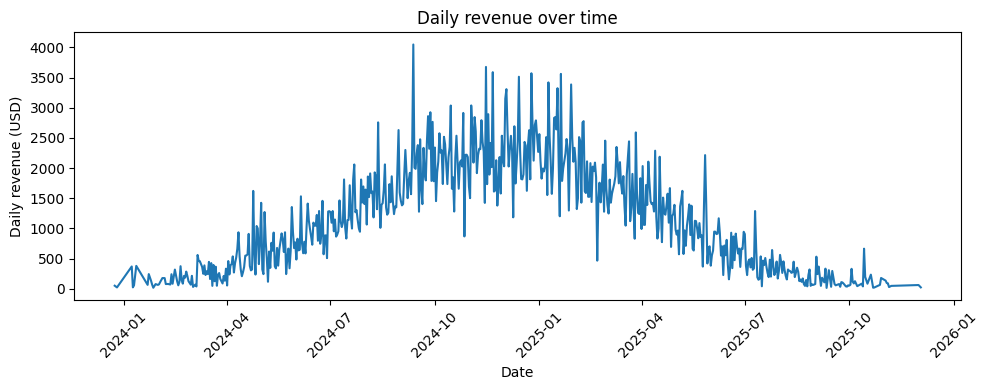

In [21]:
# 6.Plot a simple line chart of daily revenue using matplotlib.
daily_revenue = (
    df_orders
    .groupby("date")["paid_price"]
    .sum()
    .rename("revenue")
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.plot(daily_revenue["date"], daily_revenue["revenue"])
plt.xlabel("Date")
plt.ylabel("Daily revenue (USD)")
plt.title("Daily revenue over time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("daily_revenue.png", dpi=300)
plt.show()

In [22]:
# Showing all the results

# 1.Top 5 days by revenue (YYYY-MM-dd)
print("Top 5 days by revenue (YYYY-MM-dd):")
print(top_5_days, "\n")

# 2.Number of unique users
print("Number of unique users:")
print("All records:", len(df_users))
print("Unique users:", num_unique_users, "\n")

# 3.Number of unique sets of authors
print("Number of unique sets of authors:")
print("All records:", len(df_books))
print("Unique sets of authors:", num_unique_author_sets, "\n")

# 4.Name of most popular author(s)
print("Most popular author(s), by sold book count:" "\n", best_author, best_sold, "\n")

# 5.Best buyer (with aliases) as an array of ids ([id1, id2, ...])
print("Best buyer id(s):", best_ids_flat)

Top 5 days by revenue (YYYY-MM-dd):
          date  paid_price
229 2024-09-12    4048.848
293 2024-11-15    3677.170
299 2024-11-21    3590.082
333 2024-12-25    3572.110
359 2025-01-20    3561.500 

Number of unique users:
All records: 2810
Unique users: 2663 

Number of unique sets of authors:
All records: 741
Unique sets of authors: 293 

Most popular author(s), by sold book count:
 ('Hershel Treutel', 'Miss Modesto Denesik', 'Sen. Trula Bosco') 163 

Best buyer id(s): [53583, 55058, 55420]


In [23]:
# 1) Top 5 days by revenue
df_top_days = top_5_days.copy()

# 2) Number of unique users
df_unique_users_summary = pd.DataFrame([{
    "all_records": len(df_users),
    "unique_users": num_unique_users,
}])

# 3) Number of unique sets of authors
df_unique_author_sets_summary = pd.DataFrame([{
    "all_records": len(df_books),
    "unique_sets_of_authors": num_unique_author_sets,
}])

# 4) Most popular author(s) – obsługa wielu autorów
if isinstance(best_author, tuple):
    authors = list(best_author)
elif isinstance(best_author, list):
    authors = best_author
else:
    authors = [best_author]

df_top_authors = pd.DataFrame(
    [{"author": a, "sold_book_count": best_sold} for a in authors]
)

# 5) Best buyer id(s)
df_best_buyers = pd.DataFrame({
    "buyer_id": best_ids_flat
})

with pd.ExcelWriter("data_summary_2.xlsx") as writer:
    df_top_days.to_excel(writer, sheet_name="top5_days_by_revenue", index=False)
    df_unique_users_summary.to_excel(writer, sheet_name="unique_users_summary", index=False)
    df_unique_author_sets_summary.to_excel(writer, sheet_name="unique_author_sets_authors", index=False)
    df_top_authors.to_excel(writer, sheet_name="top_authors_by_sold_books", index=False)
    df_best_buyers.to_excel(writer, sheet_name="best_buyer_ids", index=False)